# NYS_08_predict_raster

Predict wetland classes for a full raster extent using a trained U-Net model.

This notebook:
1. Loads and stacks input rasters (matching training band order)
2. Applies normalization from training metadata
3. Predicts using overlapping center-crop with Gaussian blending (eliminates edge artifacts)
4. Saves predictions as a georeferenced GeoTIFF

**Artifact-free prediction**: Each 128×128 patch uses only its center 64×64 pixels. Patches overlap by 50% and are blended with Gaussian weights, ensuring smooth transitions with no visible tile seams.

In [1]:
from pathlib import Path
import os

workdir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/")
os.chdir(workdir)
print(f"Current working directory: {Path.cwd()}")

Current working directory: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL


In [2]:
import torch
import numpy as np
import rasterio
from rasterio.transform import from_bounds
import json
from pathlib import Path
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
# Import model and utilities
script_dir = Path("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/Python_Code_Analysis/DL_Implement")
sys.path.insert(0, str(script_dir))

from NYS_04_dataset import find_patch_files, load_and_merge_metadata
from NYS_05_unet_model import UNet

Current working directory: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL

Configuration:
  data_dir: Data/Patches_v2
  cluster_id: 208
  huc_id: All HUCs in cluster


## Configuration

Set the input parameters for prediction:

In [4]:
# === CONFIGURATION ===

# Model and metadata settings (must match training)
data_dir = Path("Data/Patches_v2")
cluster_id = 208
huc_id = None  # None to merge all HUCs in cluster
model_path = workdir / "Models/best_model.pth"

# HUC to predict (for finding input rasters)
predict_huc = "041402011002"  # Change this to predict different areas

# Prediction settings
patch_size = 128
crop_margin = 32  # Pixels to discard from each edge (center 64x64 used from each 128x128 patch)
batch_size = 16  # Number of patches to predict at once

# Output
output_dir = Path("Data/Predictions")
output_dir.mkdir(exist_ok=True)

print(f"Model: {model_path}")
print(f"Predict HUC: {predict_huc}")
print(f"Patch size: {patch_size}, Crop margin: {crop_margin} (using center {patch_size - 2*crop_margin}x{patch_size - 2*crop_margin})")
print(f"Output directory: {output_dir}")

Model: /Users/Anthony/Data and Analysis Local/NYS_Wetlands_DL/Models/best_model.pth
Predict HUC: 041402011002
Patch size: 128, Crop margin: 32 (using center 64x64)
Output directory: Data/Predictions


## Load Metadata and Model

In [5]:
# Load training metadata for normalization parameters
files = find_patch_files(data_dir, cluster_id, huc_id)
metadata = load_and_merge_metadata(files["metadata_files"])

print(f"Metadata loaded:")
print(f"  in_channels: {metadata['in_channels']}")
print(f"  num_classes: {metadata['num_classes']}")
print(f"  band_names: {metadata['band_names']}")
print(f"  class_names: {metadata['class_names']}")

Metadata loaded:
  in_channels: 11
  num_classes: 2
  band_names: ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']
  class_names: ['Background', 'WET']


In [6]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet(
    in_channels=metadata["in_channels"],
    num_classes=metadata["num_classes"],
    base_filters=32
)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"\nLoaded model from epoch {checkpoint['epoch'] + 1}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")
print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")

Using device: mps

Loaded model from epoch 25
Validation loss: 0.4122
Validation accuracy: 0.8130


## Load and Stack Input Rasters

Load the same rasters used during training, in the same band order.

In [7]:
# Raster input configuration (must match NYS_03_create_patches_v2.ipynb)
raster_inputs = [
    {
        "name": "naip",
        "path_pattern": "Data/NAIP/HUC_NAIP_Processed/*{huc}*.tif",
        "bands": None,  # Read from raster descriptions
    },
    {
        "name": "dem",
        "path_pattern": "Data/TerrainProcessed/HUC_DEMs/*{huc}.tif",
        "bands": ["dem"],
    },
    {
        "name": "chm",
        "path_pattern": "Data/CHMs/HUC_CHMs/*{huc}*.tif",
        "bands": ["chm"],
    },
    {
        "name": "terrain",
        "path_pattern": "Data/TerrainProcessed/HUC_TerrainMetrics/*{huc}*5m.tif",
        "bands": None,  # Read from descriptions
    },
]

print(f"Configured {len(raster_inputs)} raster inputs")

Configured 4 raster inputs


In [8]:
def load_and_stack_rasters(raster_inputs, huc_id, expected_bands):
    """
    Load rasters and stack them in the expected band order.
    
    Args:
        raster_inputs: List of raster configuration dicts
        huc_id: HUC ID to substitute in path patterns
        expected_bands: List of band names in expected order (from metadata)
    
    Returns:
        stacked_data: numpy array (bands, height, width)
        profile: rasterio profile for output
        band_names: List of band names as loaded
    """
    bands = {}
    band_names = []
    profile = None
    
    for raster_cfg in raster_inputs:
        pattern = raster_cfg["path_pattern"].replace("{huc}", huc_id)
        matches = list(Path(".").glob(pattern))
        
        if not matches:
            raise FileNotFoundError(f"No files found for {raster_cfg['name']}: {pattern}")
        
        raster_path = matches[0]
        print(f"  Loading {raster_cfg['name']}: {raster_path.name}")
        
        with rasterio.open(raster_path) as src:
            data = src.read()
            
            # Store profile from first raster for output
            if profile is None:
                profile = src.profile.copy()
            
            # Determine band names
            if raster_cfg["bands"] is not None:
                names = raster_cfg["bands"]
            elif src.descriptions and all(src.descriptions):
                names = list(src.descriptions)
            else:
                names = [f"{raster_cfg['name']}_{j+1}" for j in range(src.count)]
            
            # Store each band
            for idx, name in enumerate(names):
                bands[name] = data[idx]
                band_names.append(name)
                print(f"    - {name}: shape {data[idx].shape}")
    
    # Stack in expected order (matching training)
    print(f"\nStacking bands in training order: {expected_bands}")
    stacked_list = []
    for band_name in expected_bands:
        if band_name not in bands:
            raise ValueError(f"Expected band '{band_name}' not found in loaded rasters")
        stacked_list.append(bands[band_name])
    
    stacked_data = np.stack(stacked_list, axis=0)
    
    return stacked_data, profile, expected_bands

# Load rasters
print(f"Loading rasters for HUC {predict_huc}...\n")
input_data, raster_profile, loaded_bands = load_and_stack_rasters(
    raster_inputs, 
    predict_huc, 
    metadata["band_names"]
)

print(f"\nInput stack shape: {input_data.shape}")
print(f"Data type: {input_data.dtype}")

Loading rasters for HUC 041402011002...

  Loading naip: cluster_208_huc_041402011002_NAIP_metrics.tif
    - r: shape (12000, 18000)
    - g: shape (12000, 18000)
    - b: shape (12000, 18000)
    - nir: shape (12000, 18000)
    - ndvi: shape (12000, 18000)
    - ndwi: shape (12000, 18000)
  Loading dem: cluster_208_huc_041402011002.tif
    - dem: shape (12000, 18000)
  Loading chm: cluster_208_huc_041402011002_CHM.tif
    - chm: shape (12000, 18000)
  Loading terrain: cluster_208_huc_041402011002_terrain_slp_5m.tif
    - slope_5m: shape (12000, 18000)
    - TPI_5m: shape (12000, 18000)
    - Geomorph_5m: shape (12000, 18000)

Stacking bands in training order: ['r', 'g', 'b', 'nir', 'ndvi', 'ndwi', 'dem', 'chm', 'slope_5m', 'TPI_5m', 'Geomorph_5m']

Input stack shape: (11, 12000, 18000)
Data type: float32


## Normalize Input Data

Apply the same normalization used during training.

In [9]:
def normalize_stack(data, band_names, normalization):
    """
    Normalize a raster stack using training normalization parameters.
    Handles NaN/NoData values by tracking them separately.

    Args:
        data: numpy array (bands, height, width)
        band_names: List of band names
        normalization: Dict of normalization parameters from metadata

    Returns:
        normalized: Normalized data array (float32) with NaN filled to 0
        nodata_mask: Boolean mask where True = NoData (any band has NaN)
    """
    normalized = data.astype(np.float32).copy()

    # Create NoData mask (True where ANY band has NaN)
    nodata_mask = np.any(np.isnan(data), axis=0)
    nan_count = np.sum(nodata_mask)
    total_pixels = nodata_mask.size
    print(f"NoData pixels: {nan_count:,} ({100*nan_count/total_pixels:.1f}%)\n")

    for i, band_name in enumerate(band_names):
        norm_params = normalization[band_name]

        if norm_params["type"] == "divide":
            normalized[i] = normalized[i] / norm_params["value"]
        elif norm_params["type"] == "shift_scale":
            normalized[i] = (normalized[i] + norm_params["shift"]) / norm_params["scale"]
        elif norm_params["type"] == "minmax":
            min_val = norm_params["min"]
            max_val = norm_params["max"]
            if max_val - min_val > 0:
                normalized[i] = (normalized[i] - min_val) / (max_val - min_val)
            else:
                normalized[i] = 0.0

        # Report stats ignoring NaN
        band_min = np.nanmin(normalized[i])
        band_max = np.nanmax(normalized[i])
        print(f"  {band_name}: [{band_min:.3f}, {band_max:.3f}]")

    # Fill NaN with 0 for model input (mask will track these locations)
    normalized = np.nan_to_num(normalized, nan=0.0)

    return normalized, nodata_mask

print("Normalizing input data...\n")
normalized_data, nodata_mask = normalize_stack(input_data, metadata["band_names"], metadata["normalization"])
print(f"\nNormalized shape: {normalized_data.shape}")
print(f"NoData mask shape: {nodata_mask.shape}")

Normalizing input data...

NoData pixels: 151,751,386 (70.3%)

  r: [0.000, 1.000]
  g: [0.067, 1.000]
  b: [0.204, 1.000]
  nir: [0.043, 1.000]
  ndvi: [0.103, 1.000]
  ndwi: [0.152, 0.912]
  dem: [0.408, 0.936]
  chm: [0.000, 0.943]
  slope_5m: [0.000, 0.908]
  TPI_5m: [0.342, 0.962]
  Geomorph_5m: [0.100, 1.000]

Normalized shape: (11, 12000, 18000)
NoData mask shape: (12000, 18000)


## Overlapping Center-Crop with Gaussian Blending

Predict patches across the entire raster using a two-stage approach to eliminate edge artifacts:

1. **Center-crop**: Only use the center 64×64 pixels from each 128×128 patch, discarding the outer 32 pixels where U-Net has boundary effects

2. **Overlapping + Gaussian blending**: Step by 32 pixels (50% overlap), so each output pixel is covered by up to 4 center crops. Blend using Gaussian weights (high weight at center, low at edges) for smooth transitions with no visible seams.

In [10]:
def create_gaussian_weight_map(size, sigma_fraction=0.3):
    """
    Create a 2D Gaussian weight map - high in center, tapering to edges.
    
    Args:
        size: Size of the square weight map
        sigma_fraction: Sigma as fraction of size (larger = flatter, smaller = more peaked)
    
    Returns:
        weight_map: 2D numpy array of shape (size, size)
    """
    center = size / 2
    sigma = size * sigma_fraction
    
    y, x = np.ogrid[:size, :size]
    # Offset by 0.5 to center the Gaussian on pixel centers
    dist_sq = (x - center + 0.5)**2 + (y - center + 0.5)**2
    weight_map = np.exp(-dist_sq / (2 * sigma**2))
    
    return weight_map.astype(np.float32)


def predict_raster(model, data, patch_size, crop_margin, batch_size, device, num_classes):
    """
    Predict on a full raster using overlapping center-crop with Gaussian blending.
    
    Uses center portion of each patch prediction to avoid edge artifacts,
    with overlapping centers blended using Gaussian weights for smooth transitions.
    
    Args:
        model: Trained PyTorch model
        data: Normalized input array (bands, height, width)
        patch_size: Size of prediction patches (e.g., 128)
        crop_margin: Pixels to discard from each edge (e.g., 32 means use center 64x64)
        batch_size: Number of patches per batch
        device: PyTorch device
        num_classes: Number of output classes
    
    Returns:
        predictions: Array of predicted class labels (height, width)
        probabilities: Array of class probabilities (num_classes, height, width)
    """
    _, height, width = data.shape
    center_size = patch_size - 2 * crop_margin
    
    # Overlap centers by 50% - step by half the center size
    stride = center_size // 2
    
    # Create Gaussian weight map for the center region
    weight_map = create_gaussian_weight_map(center_size, sigma_fraction=0.3)
    
    # Pad input with reflection to ensure full coverage of all pixels
    # Need enough padding so edge pixels can be in the center of a patch
    pad_h = crop_margin + (stride - (height % stride)) % stride + center_size
    pad_w = crop_margin + (stride - (width % stride)) % stride + center_size
    
    padded = np.pad(
        data, 
        ((0, 0), (crop_margin, pad_h), (crop_margin, pad_w)), 
        mode='reflect'
    )
    _, padded_h, padded_w = padded.shape
    
    print(f"Raster size: {height} x {width}")
    print(f"Padded size: {padded_h} x {padded_w}")
    print(f"Patch size: {patch_size}, Center size: {center_size}, Stride: {stride}")
    print(f"Crop margin: {crop_margin}, Overlap: {center_size - stride} pixels (50%)")
    
    # Output arrays with weighted accumulation
    prob_sum = np.zeros((num_classes, height, width), dtype=np.float32)
    weight_sum = np.zeros((height, width), dtype=np.float32)
    
    # Grid positions - step by stride for overlapping coverage
    row_positions = list(range(0, padded_h - patch_size + 1, stride))
    col_positions = list(range(0, padded_w - patch_size + 1, stride))
    
    positions = [(r, c) for r in row_positions for c in col_positions]
    total_patches = len(positions)
    
    print(f"Grid: {len(row_positions)} rows x {len(col_positions)} cols = {total_patches} patches")
    
    # Process in batches
    model.eval()
    with torch.no_grad():
        for batch_start in tqdm(range(0, total_patches, batch_size), desc="Predicting"):
            batch_positions = positions[batch_start:batch_start + batch_size]
            
            # Extract patches from padded data
            patches = []
            for row, col in batch_positions:
                patch = padded[:, row:row+patch_size, col:col+patch_size]
                patches.append(patch)
            
            # Stack and convert to tensor
            batch_tensor = torch.from_numpy(np.stack(patches)).to(device)
            
            # Predict
            outputs = model(batch_tensor)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            
            # Extract center of each prediction and accumulate with Gaussian weights
            for i, (row, col) in enumerate(batch_positions):
                # Get center region of prediction
                center_probs = probs[i, :, crop_margin:crop_margin+center_size, crop_margin:crop_margin+center_size]
                
                # Map to original image coordinates
                # Patch at (row, col) in padded space has center starting at row in original space
                orig_r = row
                orig_c = col
                
                # Compute valid region (clip to image bounds)
                orig_r_end = min(orig_r + center_size, height)
                orig_c_end = min(orig_c + center_size, width)
                
                # Skip if completely outside bounds
                if orig_r >= height or orig_c >= width:
                    continue
                
                # Handle negative start coordinates (shouldn't happen with our padding, but safe)
                src_r_start = max(0, -orig_r)
                src_c_start = max(0, -orig_c)
                orig_r = max(0, orig_r)
                orig_c = max(0, orig_c)
                
                # Sizes to copy
                copy_h = orig_r_end - orig_r
                copy_w = orig_c_end - orig_c
                
                # Extract the valid portions
                valid_probs = center_probs[:, src_r_start:src_r_start+copy_h, src_c_start:src_c_start+copy_w]
                valid_weights = weight_map[src_r_start:src_r_start+copy_h, src_c_start:src_c_start+copy_w]
                
                # Accumulate weighted probabilities
                prob_sum[:, orig_r:orig_r_end, orig_c:orig_c_end] += valid_probs * valid_weights
                weight_sum[orig_r:orig_r_end, orig_c:orig_c_end] += valid_weights
    
    # Normalize by accumulated weights
    weight_sum = np.maximum(weight_sum, 1e-8)  # Avoid division by zero
    probabilities = prob_sum / weight_sum
    
    # Get final predictions
    predictions = np.argmax(probabilities, axis=0).astype(np.uint8)
    
    return predictions, probabilities

In [11]:
# Run prediction
print(f"Running prediction on HUC {predict_huc}...\n")

predictions, probabilities = predict_raster(
    model=model,
    data=normalized_data,
    patch_size=patch_size,
    crop_margin=crop_margin,
    batch_size=batch_size,
    device=device,
    num_classes=metadata["num_classes"]
)

print(f"\nPrediction complete!")
print(f"Output shape: {predictions.shape}")
print(f"Unique classes: {np.unique(predictions)}")

Running prediction on HUC 041402011002...

Raster size: 12000 x 18000
Padded size: 12128 x 18144
Patch size: 128, Center size: 64, Stride: 32
Crop margin: 32, Overlap: 32 pixels (50%)
Grid: 376 rows x 564 cols = 212064 patches


Predicting: 100%|█████████████████████████████████████████████████████████████████████████████| 13254/13254 [05:26<00:00, 40.60it/s]



Prediction complete!
Output shape: (12000, 18000)
Unique classes: [0 1]


## Save Predictions as GeoTIFF

In [12]:
# Apply NoData mask to predictions
predictions_masked = predictions.copy()
predictions_masked[nodata_mask] = 255  # Use 255 as NoData value

# Save predicted classes
output_path = output_dir / f"prediction_{predict_huc}.tif"

# Update profile for output
out_profile = raster_profile.copy()
out_profile.update(
    dtype=rasterio.uint8,
    count=1,
    compress='lzw',
    nodata=255
)

with rasterio.open(output_path, 'w', **out_profile) as dst:
    dst.write(predictions_masked, 1)
    dst.set_band_description(1, "wetland_class")

print(f"Saved predictions to: {output_path}")
print(f"NoData pixels (value=255): {np.sum(predictions_masked == 255):,}")

# Optionally save probability layers
save_probabilities = True

if save_probabilities:
    prob_path = output_dir / f"prediction_{predict_huc}_probs.tif"
    
    # Apply NoData mask to probabilities
    probabilities_masked = probabilities.copy()
    for i in range(probabilities_masked.shape[0]):
        probabilities_masked[i][nodata_mask] = np.nan
    
    prob_profile = raster_profile.copy()
    prob_profile.update(
        dtype=rasterio.float32,
        count=metadata["num_classes"],
        compress='lzw',
        nodata=np.nan
    )
    
    with rasterio.open(prob_path, 'w', **prob_profile) as dst:
        for i, class_name in enumerate(metadata["class_names"]):
            dst.write(probabilities_masked[i], i + 1)
            dst.set_band_description(i + 1, f"prob_{class_name}")
    
    print(f"Saved probabilities to: {prob_path}")

Saved predictions to: Data/Predictions/prediction_041402011002.tif
NoData pixels (value=255): 151,751,386
Saved probabilities to: Data/Predictions/prediction_041402011002_probs.tif


## Visualize Results

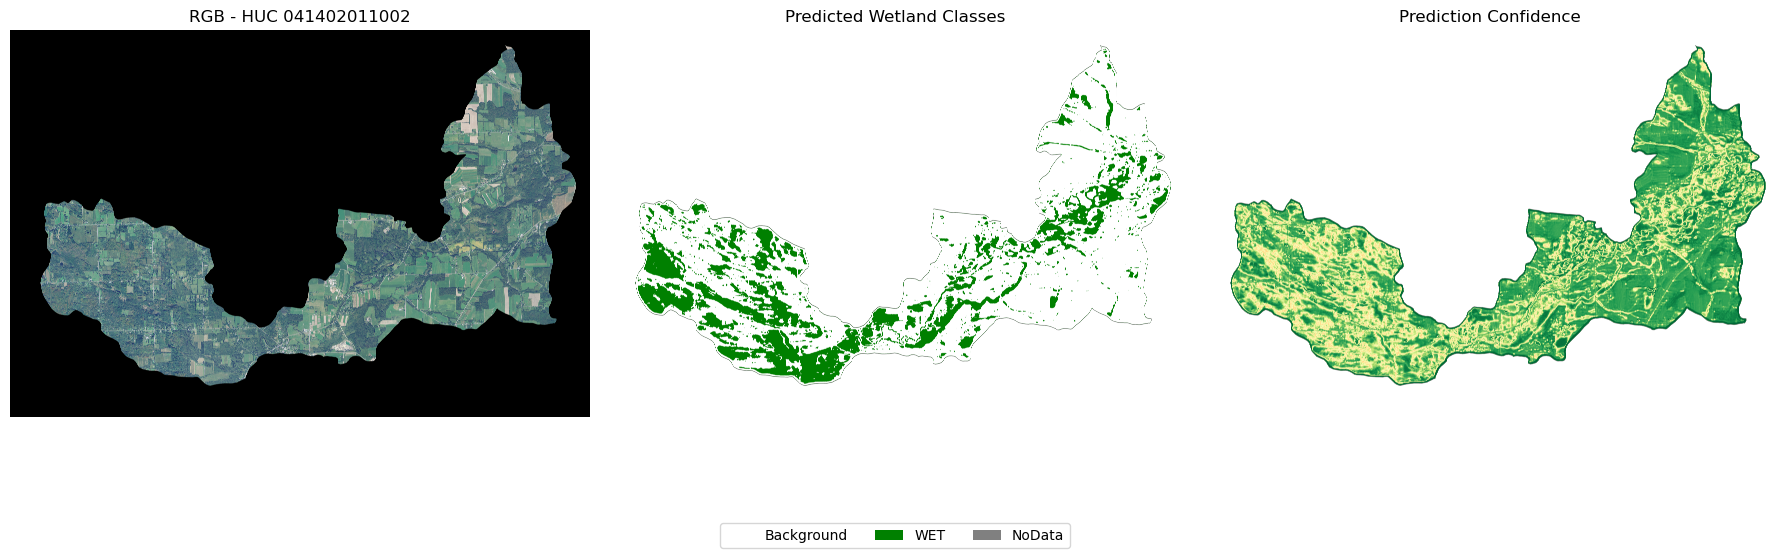


Saved visualization to: Data/Predictions/prediction_041402011002_viz.png


In [13]:
# Visualization setup
class_names = metadata["class_names"]
colors = ['white', 'green']
cmap = ListedColormap(colors)

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB composite (handle NaN by filling with 0)
rgb_idx = [metadata["band_names"].index(b) for b in ['r', 'g', 'b']]
rgb = input_data[rgb_idx].transpose(1, 2, 0) / 255.0
rgb = np.nan_to_num(rgb, nan=0.0)
rgb = np.clip(rgb, 0, 1)

axes[0].imshow(rgb)
axes[0].set_title(f"RGB - HUC {predict_huc}")
axes[0].axis('off')

# Predictions (mask NoData as gray)
pred_display = np.ma.masked_where(nodata_mask, predictions)
im = axes[1].imshow(pred_display, cmap=cmap, vmin=0, vmax=len(class_names)-1)
axes[1].imshow(nodata_mask, cmap='gray', alpha=0.5 * nodata_mask.astype(float))  # Gray overlay for NoData
axes[1].set_title("Predicted Wetland Classes")
axes[1].axis('off')

# Max probability (confidence) - mask NoData
max_prob = np.max(probabilities, axis=0)
max_prob_masked = np.ma.masked_where(nodata_mask, max_prob)
axes[2].imshow(max_prob_masked, cmap='RdYlGn', vmin=0.2, vmax=1.0)
axes[2].set_title("Prediction Confidence")
axes[2].axis('off')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
legend_elements.append(Patch(facecolor='gray', label='NoData'))
fig.legend(handles=legend_elements, loc='lower center', ncol=6, fontsize=10)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

# Save figure
fig_path = output_dir / f"prediction_{predict_huc}_viz.png"
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved visualization to: {fig_path}")

In [14]:
# Print class statistics (excluding NoData)
print("\nClass Distribution in Predictions (excluding NoData):")
print("-" * 50)

valid_mask = ~nodata_mask
valid_predictions = predictions[valid_mask]
total_valid = valid_predictions.size
total_nodata = np.sum(nodata_mask)

for i, class_name in enumerate(class_names):
    count = np.sum(valid_predictions == i)
    pct = (count / total_valid) * 100 if total_valid > 0 else 0
    print(f"  {class_name:12s}: {count:>10,} pixels ({pct:5.2f}%)")

print("-" * 50)
print(f"  {'Valid':12s}: {total_valid:>10,} pixels")
print(f"  {'NoData':12s}: {total_nodata:>10,} pixels")
print(f"  {'Total':12s}: {predictions.size:>10,} pixels")


Class Distribution in Predictions (excluding NoData):
--------------------------------------------------
  Background  : 47,036,838 pixels (73.21%)
  WET         : 17,211,776 pixels (26.79%)
--------------------------------------------------
  Valid       : 64,248,614 pixels
  NoData      : 151,751,386 pixels
  Total       : 216,000,000 pixels


## Batch Prediction (Optional)

Predict multiple HUCs in sequence.

In [ ]:
def predict_huc_batch(huc_list, model, raster_inputs, metadata, 
                      patch_size, crop_margin, batch_size, device, output_dir):
    """
    Predict wetland classes for multiple HUCs.
    
    Args:
        huc_list: List of HUC IDs to predict
        model: Trained model
        raster_inputs: Raster configuration
        metadata: Training metadata
        patch_size, crop_margin, batch_size: Prediction parameters
        device: PyTorch device
        output_dir: Output directory for predictions
    
    Returns:
        results: Dict with HUC IDs as keys, output paths as values
    """
    results = {}
    
    for huc_id in huc_list:
        print(f"\n{'='*60}")
        print(f"Processing HUC: {huc_id}")
        print(f"{'='*60}")
        
        try:
            # Load rasters
            input_data, profile, _ = load_and_stack_rasters(
                raster_inputs, huc_id, metadata["band_names"]
            )
            
            # Normalize (returns data and nodata_mask)
            normalized, nodata_mask = normalize_stack(
                input_data, metadata["band_names"], metadata["normalization"]
            )
            
            # Predict
            predictions, probabilities = predict_raster(
                model, normalized, patch_size, crop_margin, 
                batch_size, device, metadata["num_classes"]
            )
            
            # Apply NoData mask
            predictions[nodata_mask] = 255
            
            # Save
            output_path = output_dir / f"prediction_{huc_id}.tif"
            out_profile = profile.copy()
            out_profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=255)
            
            with rasterio.open(output_path, 'w', **out_profile) as dst:
                dst.write(predictions, 1)
            
            results[huc_id] = str(output_path)
            print(f"Saved: {output_path}")
            
        except Exception as e:
            print(f"ERROR processing {huc_id}: {e}")
            results[huc_id] = f"ERROR: {e}"
    
    return results

# Example: predict all HUCs in cluster
# Uncomment to run batch prediction:

# all_hucs = ["041402011002", "041402011004", "041402011005"]  # Add HUC IDs
# results = predict_huc_batch(
#     all_hucs, model, raster_inputs, metadata,
#     patch_size, crop_margin, batch_size, device, output_dir
# )
# print("\nBatch prediction complete!")
# for huc, path in results.items():
#     print(f"  {huc}: {path}")